In [1]:
import yaml 
import pandas as pd
import os
from collections import Counter
import numpy as np
import torch
import tqdm
import pickle
from sklearn.metrics import accuracy_score
import evaluate

In [2]:
config_path = "../configs/pcgu_config.yaml"
with open(config_path, "r") as yamlfile:
    config = yaml.load(yamlfile, Loader=yaml.FullLoader)

In [3]:
biased_label_maps = {"entailment": 0, "contradiction": 1, "neutral": 2}
main_label_maps = {"contradiction": 0, "entailment": 1, "neutral": 2}
biased_label_remaps = {v:k for k,v in biased_label_maps.items()}
main_label_remaps = {v:k for k,v in main_label_maps.items()}

In [4]:
# Consider Entailment class  
# if a biased model is correct: 
#  - a main model is correct -> it's actually entailment samples -> disadvantaged samples
#  - a main model is incorrect -> *** advantaged samples
# if a biased model is incorrect -> disadvantaged samples 

In [5]:
seed = 42
path = f'../../pickles/advantaged/{seed}_inferences.pickle'
with open(path, 'rb') as handle: 
    main_df = pickle.load(handle)
    biased_df = pickle.load(handle)
main_df['results'] = main_df['results'].apply(lambda row: bool(row))
entail_main_df = main_df.loc[main_df['gold_label'] == main_label_maps['entailment']]
entail_biased_df = biased_df.loc[biased_df['gold_label'] == biased_label_remaps[0]]
entail_biased_df.shape == entail_main_df.shape
print(entail_biased_df.shape )
print(entail_main_df.shape)

(130899, 8)
(130899, 6)


In [6]:
# if a biased model is correct: 
#  - a main model is incorrect -> *** advantaged samples

In [72]:
# select samples base on main model 
advantaged  = []
for idx in range(entail_main_df.shape[0]):
    if entail_main_df['results'].iloc[idx] ==  False and entail_biased_df['results'].iloc[idx] == True:
        advantaged.append(True)
    else: 
        advantaged.append(False)

In [73]:
advantaged_main = entail_main_df[advantaged]
advantaged_bias = entail_biased_df[advantaged]
advantaged_main.shape[0] == advantaged_bias.shape[0]

True

In [74]:
advantaged_main.head()

,gold_label,sentence1,sentence2,probs,predictions,results
140,1,"In 2000, GNP was less than GDP because income ...",The US paid more to the rest of the world than...,"[tensor(0.6651), tensor(0.2072), tensor(0.1277)]",0,False
177,1,okay pro football i like two teams one the New...,The New York Giants and Raiders are my favorit...,"[tensor(0.0063), tensor(0.4472), tensor(0.5465)]",2,False
338,1,they use the the injection thing or whatever i...,They use lethal injection.,"[tensor(0.0175), tensor(0.1599), tensor(0.8226)]",2,False
357,1,i think on the local elections it's actually u...,I think more people vote during the presidenti...,"[tensor(0.2607), tensor(0.3458), tensor(0.3935)]",2,False
712,1,Physicians are unlikely to screen if it affect...,Physicians are doctors for children.,"[tensor(0.1554), tensor(0.0077), tensor(0.8369)]",2,False


In [75]:
advantaged_bias.head()

,gold_label,sentence1,sentence2,bias_probs,predictions,results,gold_label_ids,prediction_ids
140,entailment,"In 2000, GNP was less than GDP because income ...",The US paid more to the rest of the world than...,"[0.5558644133, 0.263421695, 0.18071389170000002]",entailment,True,0,0
177,entailment,okay pro football i like two teams one the New...,The New York Giants and Raiders are my favorit...,"[0.4405454292, 0.31046144140000004, 0.2489931294]",entailment,True,0,0
338,entailment,they use the the injection thing or whatever i...,They use lethal injection.,"[0.3791886834, 0.3314555106, 0.289355806]",entailment,True,0,0
357,entailment,i think on the local elections it's actually u...,I think more people vote during the presidenti...,"[0.5033300255000001, 0.285967647, 0.2107023274]",entailment,True,0,0
712,entailment,Physicians are unlikely to screen if it affect...,Physicians are doctors for children.,"[0.4530503587, 0.30581083400000003, 0.2411388073]",entailment,True,0,0


In [76]:
bias_probs = []
for row_idx, row  in advantaged_bias.iterrows():
    bias_probs.append(row['bias_probs'])
bias_probs = torch.tensor(bias_probs)

In [77]:
biased_label_maps.keys()

dict_keys(['entailment', 'contradiction', 'neutral'])

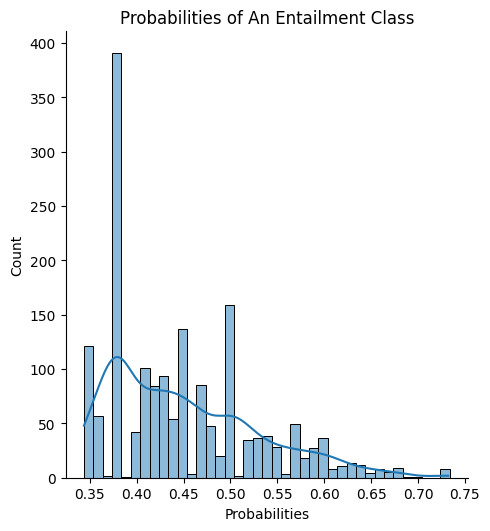

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
    
ax = sns.displot(bias_probs[:,biased_label_maps['entailment']], kde=True,binwidth=0.010).set(title='Probabilities of An Entailment Class')
ax.set(xlabel='Probabilities', ylabel='Count')
plt.show()

In [79]:
biased_label_maps

{'entailment': 0, 'contradiction': 1, 'neutral': 2}

In [80]:
probs = {}

for idx, row in advantaged_bias.iterrows():
    for label_text in biased_label_maps.keys():
        if label_text not in probs.keys(): probs[label_text] = []
        probs[label_text].append(row['bias_probs'][biased_label_maps[label_text]])

In [81]:
for label_text in probs.keys():
    print(f'{label_text} : {len(probs[label_text])}')
    advantaged_bias[label_text + '_probs'] = probs[label_text]

entailment : 1754
contradiction : 1754
neutral : 1754


/tmp/ipykernel_265473/779887114.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  advantaged_bias[label_text + '_probs'] = probs[label_text]
/tmp/ipykernel_265473/779887114.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  advantaged_bias[label_text + '_probs'] = probs[label_text]
/tmp/ipykernel_265473/779887114.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: h

In [98]:
clean_advantaged_bias  = advantaged_bias[advantaged_bias['entailment_probs'] > 0.34]

In [99]:
(clean_advantaged_bias.shape[0] / advantaged_bias.shape[0]) * 100

100.0

In [102]:
advantaged_bias['entailment_probs'].min(), advantaged_bias['entailment_probs'].max()

(0.3438287613, 0.7320638385)